#  Modeling

This notebook will be used to create a model using generated test data.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd

from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import util

In [3]:
df = pd.read_csv('../data/features.csv', index_col=0)

In [4]:
target = 'Survived'

train = df.loc[pd.notnull(df['Survived'])]
test = df.loc[pd.isnull(df['Survived'])]

y = train[target]
labels = test['Id']

del train[target]
del test[target]
del train['Id']
del test['Id']

X = train.copy()

# Base Models

Train a number of different base models for our ensemble approach.

Create parameters. Taken from Anisotropic's [notebook](www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

In [5]:
seed = 1
# Random Forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_features': 'auto',
    'max_depth': 6,
    'min_samples_leaf': 2, 
    'random_state': seed
}

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_features': 'auto',
    'max_depth': 8,
    'min_samples_leaf': 2, 
    'random_state': seed
}

# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75,
    'random_state': seed
}

# Gradient Boosting
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2, 
    'random_state': seed
}

# SVM
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [6]:
rf = ensemble.RandomForestClassifier(**rf_params)
et = ensemble.ExtraTreesClassifier(**et_params)
ada = ensemble.AdaBoostClassifier(**ada_params)
gb = ensemble.GradientBoostingClassifier(**gb_params)
svc = svm.SVC(**svc_params)

In [7]:
def print_acc(scores, name):
    print('Model ' + name + ' scored accuracy of %0.5f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

In [8]:
rf_scores = cross_val_score(rf, X, y, cv=10)
et_scores = cross_val_score(et, X, y, cv=10)
ada_scores = cross_val_score(ada, X, y, cv=10)
gb_scores = cross_val_score(gb, X, y, cv=10)
svc_scores = cross_val_score(svc, X, y, cv=10)

# Print results
print_acc(rf_scores, 'rf')
print_acc(et_scores, 'et')
print_acc(ada_scores, 'ada')
print_acc(gb_scores, 'gb')
print_acc(svc_scores, 'svc')

Model rf scored accuracy of 0.83171 (+/- 0.07)
Model et scored accuracy of 0.82717 (+/- 0.07)
Model ada scored accuracy of 0.82270 (+/- 0.05)
Model gb scored accuracy of 0.81935 (+/- 0.06)
Model svc scored accuracy of 0.80920 (+/- 0.06)


Create predictions on the test set.

In [9]:
base_test_predictions = pd.DataFrame()
base_test_predictions['rf'] = rf.fit(X, y).predict(test)
base_test_predictions['et'] = et.fit(X, y).predict(test)
base_test_predictions['ada'] = ada.fit(X, y).predict(test)
base_test_predictions['gb'] = gb.fit(X, y).predict(test)
base_test_predictions['svc'] = svc.fit(X, y).predict(test)

## Feature Importance

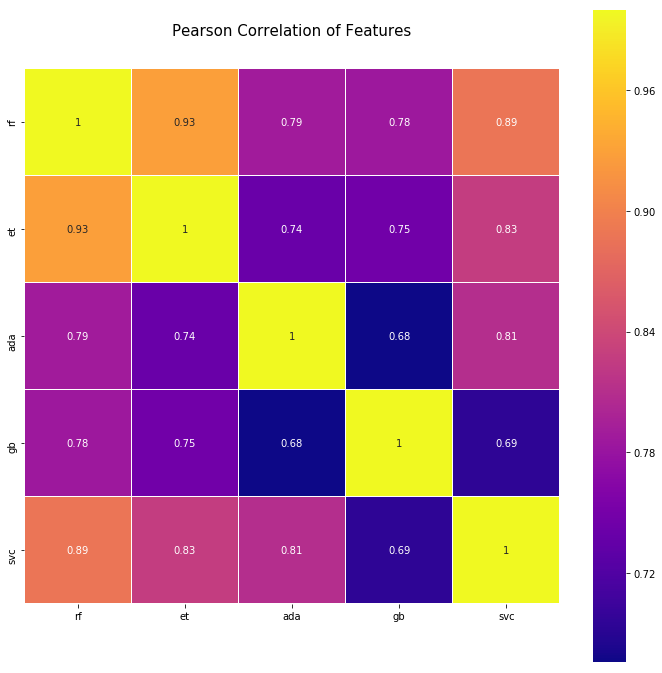

In [18]:
cmp = plt.cm.plasma
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(base_test_predictions.astype(float).corr(),linewidths=0.1, square=True, cmap=cmp, 
            linecolor='white', annot=True)

# Second Layer

In [10]:
# Try out majority predictions
#util.save_submission(base_test_predictions.mode(axis=1)[0].ravel(), labels, name='../submissions/majority.csv') 

In [21]:
X2 = pd.DataFrame()
X2['rf'] = rf.predict(X)
X2['et'] = et.predict(X)
X2['ada'] = ada.predict(X)
X2['gb'] = gb.predict(X)
X2['svc'] = svc.predict(X)